In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# @title Параметры
# PATH_TO_DATA = "dummy_df.joblib"  # <-- provide path
PATH_TO_DATA = "/content/drive/MyDrive/stocks/Data/DOGEUSDT/raw_data/DOGEUSDT_1m_2024-01-01_to_2025-05-23.joblib"
START = "2025-05-20"
END = "2025-05-23"
TIMESTAMP_COL = "timestamp"          # column with timestamps
EMA_FAST_PERIOD = 50
EMA_SLOW_PERIOD = 200
SPLITS = (0.7, 0.15, 0.15)

SEQ_LEN = 7
BATCH_SIZE = 256
UNITS_PER_LAYER = [128, 128, 64]
DROPOUT = 0.3
EPOCHS = 2
LR = 3e-3
GRAD_CLIP_NORM = 1.0
EARLY_STOPPING_PATIENCE = 5
LR_MODE = "onecycle"
ONECYCLE_MAX_LR = 8e-5
ONECYCLE_PCT_START = 0.5
LR_RESTART_PATIENCE = 4
LR_RESTART_SHRINK = 0.5
BEST_PATH = "best_lstm.weights.h5"


In [15]:
import joblib
import numpy as np
import pandas as pd

from drive.MyDrive.stocks.pretrained_rl_ppo.scr.check_data import prepare_time_series
import drive.MyDrive.stocks.pretrained_rl_ppo.scr.indicators as ind
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.q_labels_matching import enrich_q_labels_trend_one_side
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.visualisation import plot_enriched_actions_one_side
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.dataset_builder import DatasetBuilderForYourColumns
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.residual_lstm import build_stacked_residual_lstm
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.train_eval import fit_model, plot_history_curves, evaluate_dataset, confusion_and_f1_on_dataset, materialize_metrics


# from scr.check_data import prepare_time_series
# import scr.indicators as ind
# from scr.q_labels_matching import enrich_q_labels_trend_one_side
# from scr.visualisation import plot_enriched_actions_one_side
# from scr.dataset_builder import DatasetBuilderForYourColumns
# from scr.residual_lstm import build_stacked_residual_lstm
# from scr.train_eval import fit_model, plot_history_curves

In [7]:
# Load and check data
raw_df = joblib.load(PATH_TO_DATA).loc[START:END]
df = prepare_time_series(raw_df, timestamp_col=TIMESTAMP_COL)
print(f"From {df.index[0]} to {df.index[-1]}")


From 2025-05-20 00:00:00+00:00 to 2025-05-23 23:59:00+00:00


In [8]:
# Add indicators
close = df['Close'].to_numpy(np.float64)
high = df['High'].to_numpy(np.float64)
low = df['Low'].to_numpy(np.float64)
volume = df['Volume'].to_numpy(np.float64)

df['EMA_fast_raw'] = ind.ema_numba(close, EMA_FAST_PERIOD)
df['EMA_slow_raw'] = ind.ema_numba(close, EMA_SLOW_PERIOD)
df['EMA_fast'] = ind.ema_numba_safe(close, EMA_FAST_PERIOD)
df['EMA_slow'] = ind.ema_numba_safe(close, EMA_SLOW_PERIOD)
df['SMA_14'] = ind.sma_numba(close, 14)
df['ADX_14'] = ind.adx_numba(high, low, close, 14)
df['ATR_14'] = ind.atr_numba(high, low, close, 14)
df['RSI_14'] = ind.rsi_numba(close, 14)
macd, macd_signal, macd_hist = ind.macd_numba(close, 12, 26, 9)
df['MACD'] = macd
df['MACD_signal'] = macd_signal
df['MACD_hist'] = macd_hist
stoch_k, stoch_d = ind.stoch_numba(high, low, close, 14, 3)
df['STOCH_K'] = stoch_k
df['STOCH_D'] = stoch_d
boll_mid, boll_up, boll_dn = ind.bollinger_numba(close, 20, 2.0)
df['BOLL_MID'] = boll_mid
df['BOLL_UP'] = boll_up
df['BOLL_DN'] = boll_dn
df['OBV'] = ind.obv_numba(close, volume)
df['CCI_20'] = ind.cci_numba(high, low, close, 20)
df['WILLR_14'] = ind.williams_r_numba(high, low, close, 14)
df['MFI_14'] = ind.mfi_numba(high, low, close, volume, 14)
df['ROC_12'] = ind.roc_numba(close, 12)
df['VWAP_20'] = ind.vwap_numba(high, low, close, volume, 20)
piv = ind.zigzag_pivots_highlow_numba(high, low, close, 0.05, -0.05, 3, 1)
df['Pivots'] = piv
df['Pivots_expanded'] = ind.expand_pivots(piv, 2)


In [9]:
# Добавляем сигнал референс стратегии
buy_sig  = (df['EMA_fast'] > df['EMA_slow']) & (df['Close'] > df['EMA_fast']) & (df['ADX_14'] > 20)
sell_sig = (df['EMA_fast'] < df['EMA_slow']) & (df['Close'] < df['EMA_fast']) & (df['ADX_14'] > 20)
df['Signal_Rule'] = np.where(buy_sig, 1, np.where(sell_sig, -1, 0)).astype(np.int8)


In [10]:
# Q-labels
df = enrich_q_labels_trend_one_side(
    df,
    mode='tdlambda',
    H_max = 30,
    lam = 0.95,
    use_mae_penalty=False,
)
print(df[100:150].to_string())


        timestamp     Open     High      Low    Close     Volume  EMA_fast_raw  EMA_slow_raw  EMA_fast  EMA_slow    SMA_14     ADX_14    ATR_14     RSI_14      MACD  MACD_signal     MACD_hist    STOCH_K    STOCH_D  BOLL_MID   BOLL_UP   BOLL_DN         OBV      CCI_20    WILLR_14     MFI_14    ROC_12   VWAP_20  Pivots  Pivots_expanded  Signal_Rule  Pos  Q_Open  Q_Close    Q_Hold  Q_Wait  Mask_Open  Mask_Close  Mask_Hold  Mask_Wait
100  1.747705e+12  0.22801  0.22860  0.22801  0.22833  1115315.0      0.226115      0.225223  0.226115  0.225223  0.227234  34.255379  0.000476  72.863903  0.000763     0.000639  1.244527e-04  90.425532  86.846825  0.226876  0.228615  0.225137   5318966.0  124.317484   -9.574468  81.116044  0.946107  0.227219       0                0            1    1     NaN      0.0 -0.001292     NaN          0           1          1          0
101  1.747705e+12  0.22832  0.22832  0.22730  0.22730  1365253.0      0.226162      0.225243  0.226162  0.225243  0.227319  33.35591

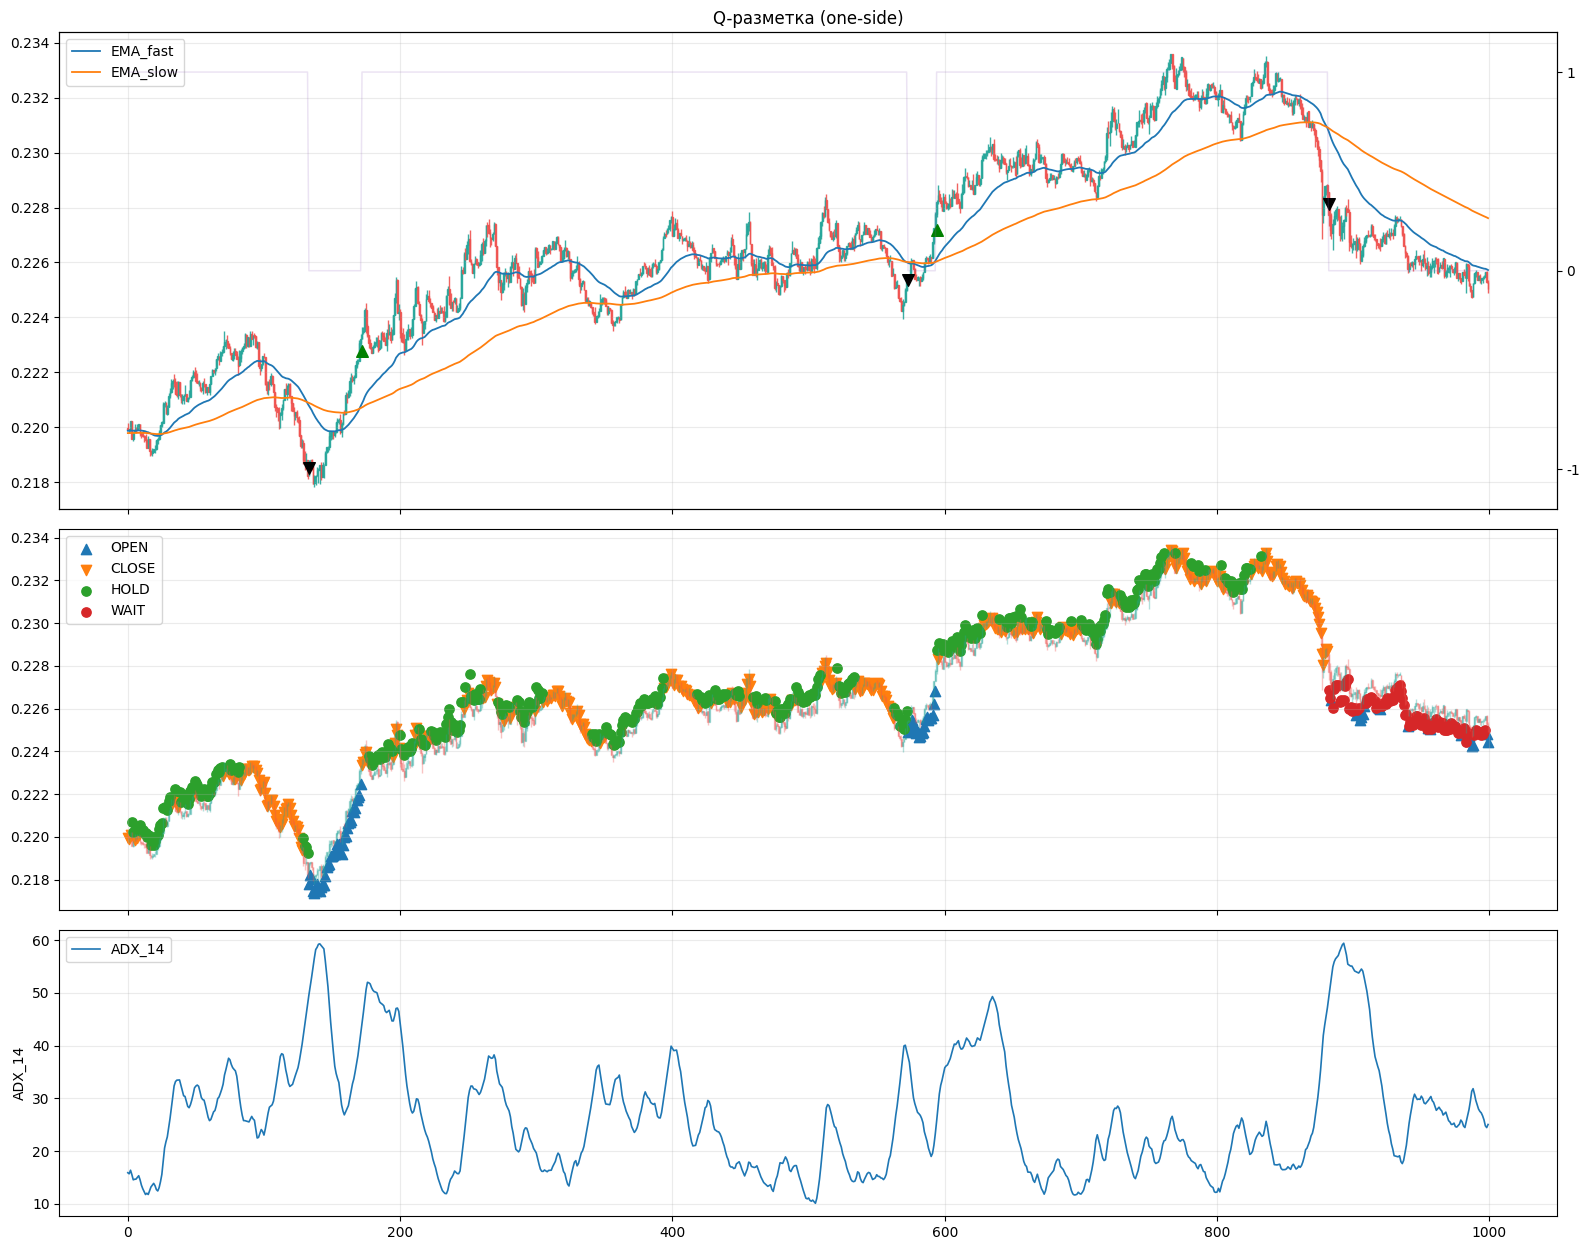

In [11]:
# Visualisation
plot_enriched_actions_one_side(
    df,
    start=1000,
    end=2000,
    indicators_price={
        'EMA_fast':df['EMA_fast'],
        'EMA_slow':df['EMA_slow'],
        },
    indicators_panels={
        'ADX_14':df['ADX_14'],
    }
)


In [12]:
# @title Нормализация и нарезка данных
enriched = df
builder = DatasetBuilderForYourColumns(
    seq_len=SEQ_LEN, norm="minmax",
    labels_from="q",
    tau=1.0, r_mode="oracle",
    splits=SPLITS,
    batch_size=BATCH_SIZE,
    sw_mode="ClassBalance",
    drop_cols=["timestamp", "BarsToExit_Open", "BarsToExit_Hold", "Signal_Rule", "Pos"],
)
splits = builder.fit_transform(enriched)
train_ds, val_ds, test_ds = builder.as_tf_datasets(splits)


Epoch 01 | train: loss 0.8608, acc 0.5262, ER -0.000003 | val: loss 0.7708, acc 0.5416, macroF1 0.2650, ER 0.000141, ICp 0.0212, ICs 0.9172
Epoch 02 | train: loss 0.7967, acc 0.4917, ER -0.000041 | val: loss 0.7267, acc 0.5607, macroF1 0.2938, ER 0.000078, ICp 0.0239, ICs 0.9279
Restored best weights from best_lstm.weights.h5


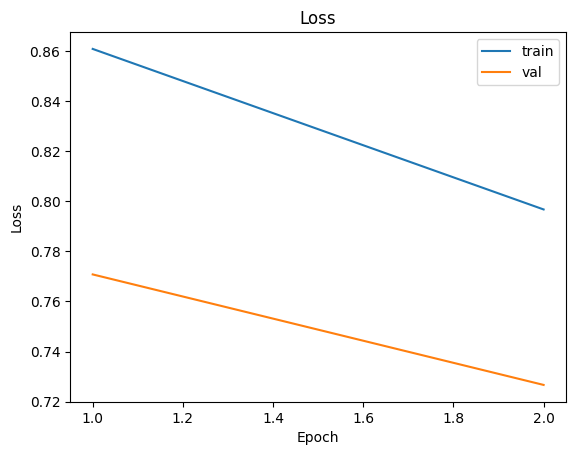

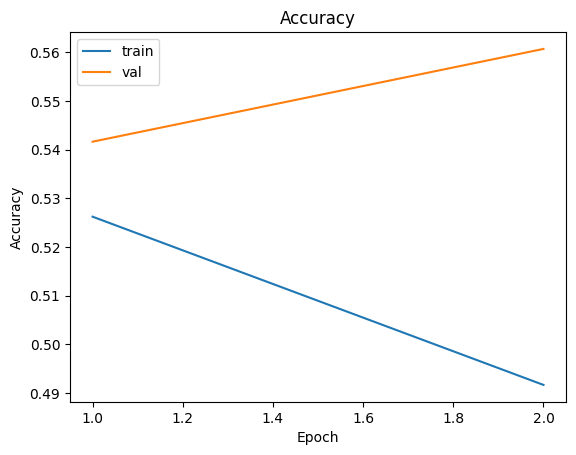

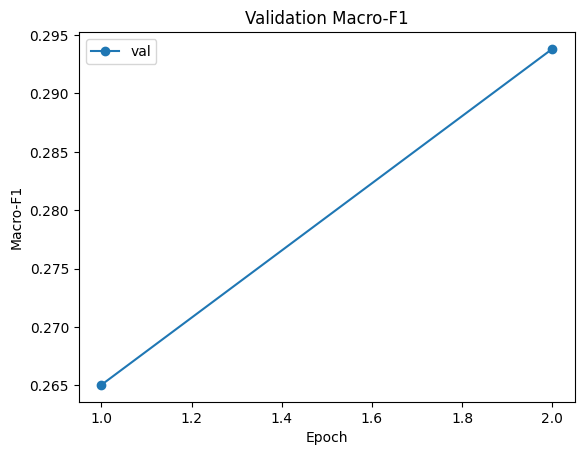

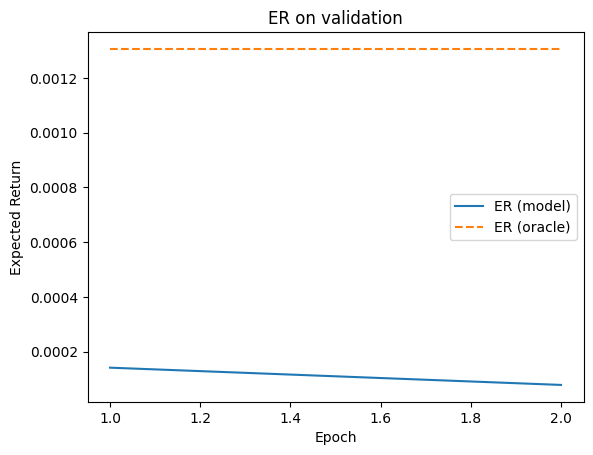

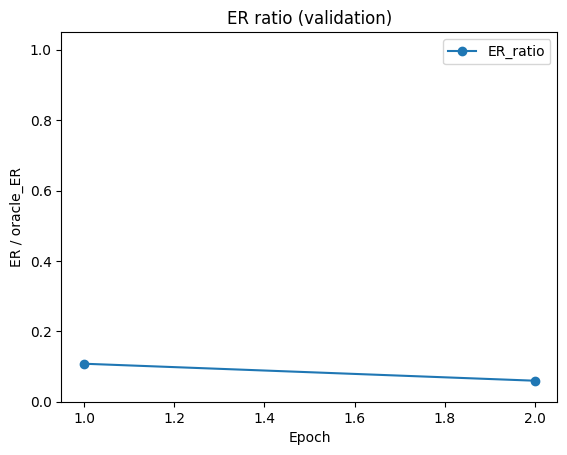

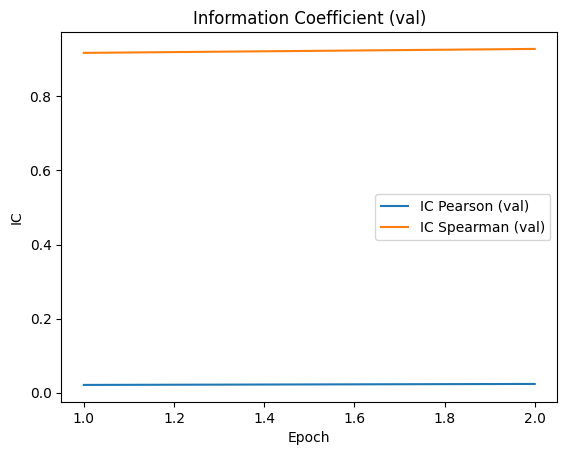

In [13]:
# @title Обучение модели
xb, _ = next(iter(train_ds.take(1)))
model = build_stacked_residual_lstm(seq_len=xb.shape[1], feature_dim=xb.shape[-1],
                                    units_per_layer=UNITS_PER_LAYER, dropout=DROPOUT)

history = fit_model(
    model,
    train_ds,
    val_ds,
    epochs=EPOCHS,
    steps_per_epoch=None,
    lr=LR,
    grad_clip_norm=GRAD_CLIP_NORM,
    early_stopping_patience=EARLY_STOPPING_PATIENCE,
    lr_mode=LR_MODE,
    onecycle_max_lr=ONECYCLE_MAX_LR,
    onecycle_pct_start=ONECYCLE_PCT_START,
    lr_restart_patience=LR_RESTART_PATIENCE,
    lr_restart_shrink=LR_RESTART_SHRINK,
    best_path=BEST_PATH,
)

plot_history_curves(history)


In [16]:
# 3) оценка на тесте
test_metrics = evaluate_dataset(model, test_ds)
print("TEST METRICS:")
for k,v in  materialize_metrics(test_metrics).items():
  print(f"{k}:{v}")


TEST METRICS:
loss:0.7035064101219177
acc:0.32435259222984314
macro_f1:0.14695578813552856
f1_per_class:[0.40310677886009216, 0.0, 0.11160717904567719, 0.0731092169880867]
exp_return:-0.0010260549606755376
oracle_ER:0.0008772215223871171
ER_ratio:-1.1696646213531494
IC_pearson:0.024961085990071297
IC_spearman:0.633545994758606


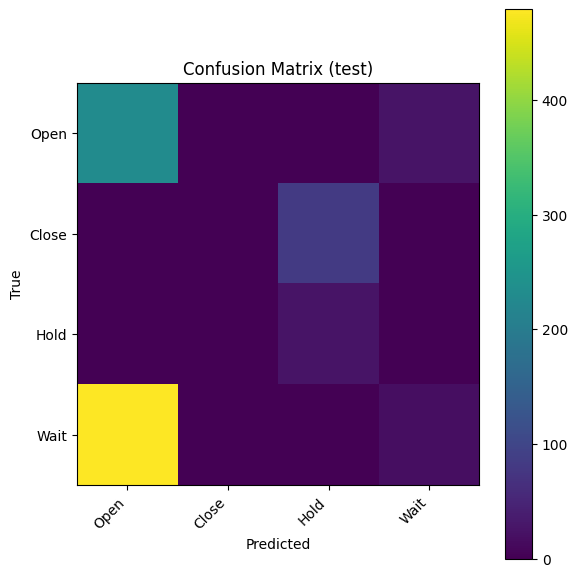

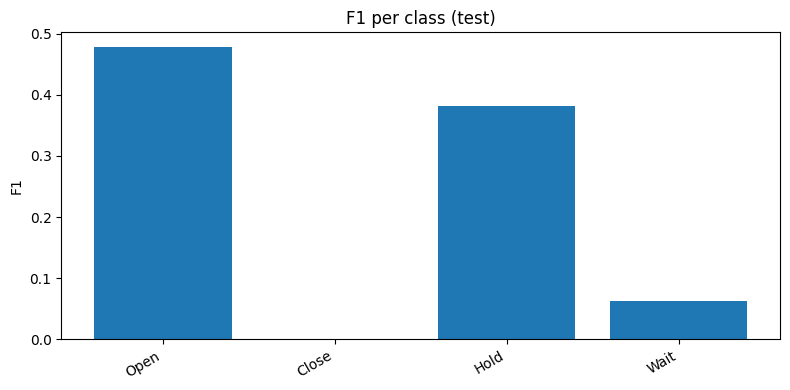

In [17]:
# 4) конфьюжн-матрица и F1 per class на тесте
cm_test, f1_test = confusion_and_f1_on_dataset(model, test_ds)